### Import the libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Import the dataset.

In [4]:
df = pd.read_csv("insurance_claims.csv")
df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,?,87200,17440,8720,61040,Honda,Accord,2006,N,NaN
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N,NaN
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,NaN
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,YES,46980,5220,5220,36540,Audi,A5,1998,N,NaN


# Data Cleaning:
- Dealing with Null Values
    - Drop the empty and unknown column "_c39"
    - Replace the '?' With None for Collision type column in case of parked car or theft vehicle incident.
    - Replace the Nan in authorities_contacted with actual string None(Simply changed the datatype).
    - Replace the '?' with Unknown for the rows in columns of property_damage and police_report_avaliable to not alter the data.
- No Duplicates
- Outliers were detected.
- Feature Specific cleaning

### Null Values

In [7]:
# drop the unnecessary column named "_c39"
df = df.drop("_c39", axis = 1)

# replace all '?' with NaN for better handling of missing values
df['collision_type'] = df['collision_type'].replace('?', np.nan)

# fill 'Not Applicable' where collision_type is missing for specific incidents
df.loc[
    df['incident_type'].isin(['Parked Car', 'Vehicle Theft']) & df['collision_type'].isnull(),
    'collision_type'
] = 'Not Applicable'


# change the datatype of 'none' to a string answer in column
df['authorities_contacted'] = df['authorities_contacted'].fillna('None')

# replace the '?' with 'unknown' in selected categorical columns
df[['property_damage', 'police_report_available']] = df[['property_damage', 'police_report_available']].replace('?', 'UNKNOWN')


#### Missing Data Handling and Cleaning Strategy
1. Dropped unnecessary columns:
The column _c39 was removed as it contained no meaningful information or was fully empty, reducing dataset clutter.

2. Standardized missing value indicators:
The dataset used '?' to represent missing or unknown values in some categorical columns. These were replaced with proper NaN values to enable more effective missing data handling using pandas.

3. Contextual imputation for collision type:
- The data type is MNAR because the it depends on incident type itself. 
- For rows where collision_type was missing (NaN), I filled values with 'Not Applicable' specifically when the incident_type was either 'Parked Car' or 'Vehicle Theft'. This is because there is no collision in case of missing vehicle or parked car.

5. Consistent string representation for missing authorities contacted:
- Type of missing data: Missing Not at Random (MNAR) — missing values likely indicate that no authorities were involved rather than data simply missing.
- Missing values in the authorities_contacted column were imputed with the string 'None' to explicitly indicate no authorities were contacted.

7. Replacement of unknown values in categorical columns:
- Type of missing data: Missing Completely at Random (MCAR) — the missingness may depend on other observed data but as per my observation property_damage is not dependent on itself or other variables as it is inconsistent through different rows.

- Columns property_damage and police_report_available had '?' entries replaced with 'UNKNOWN' to clearly label missing or uncertain responses without dropping data, preserving the full dataset for analysis.

### Duplicates

In [10]:
duplicates = df[df.duplicated()]
print(f"🔍 Number of duplicate rows: {len(duplicates)}")


🔍 Number of duplicate rows: 0


### Fix Outliers

In [12]:
outlier_summary = {}
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# IQR method
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_summary[col] = {
        'num_outliers': len(outliers),
        'percent_outliers': 100 * len(outliers) / len(df)
    }

pd.DataFrame(outlier_summary).T.sort_values('percent_outliers', ascending=False)


,num_outliers,percent_outliers
umbrella_limit,202.0,20.2
policy_annual_premium,9.0,0.9
property_claim,6.0,0.6
age,4.0,0.4
total_claim_amount,1.0,0.1
months_as_customer,0.0,0.0
bodily_injuries,0.0,0.0
vehicle_claim,0.0,0.0
injury_claim,0.0,0.0
witnesses,0.0,0.0


##### Observation: Two Columns 'Umbrella Limit' and 'policy_annual_premium' is found to have outliers.

#### Dealing with column 'Umbrella Limit'

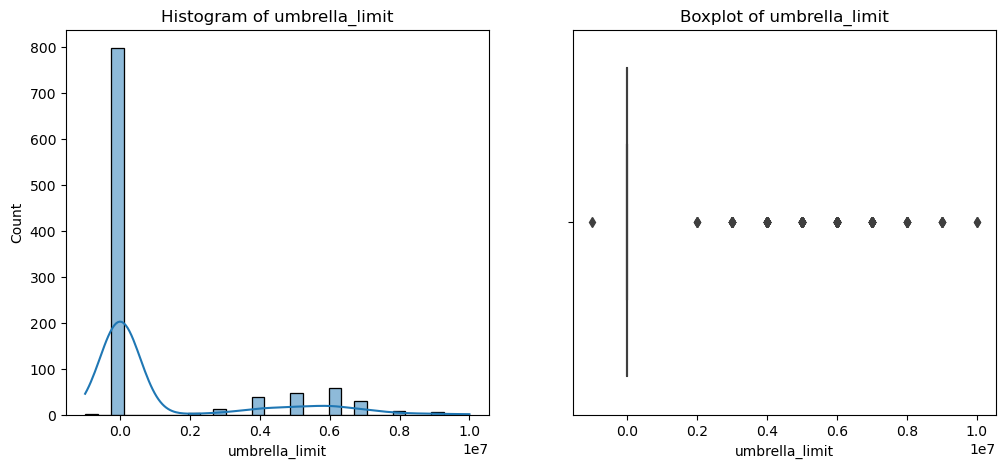

In [15]:
# plot to visualize the outliers in 'Umbrella limit'
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(df['umbrella_limit'], bins=30, kde=True)
plt.title('Histogram of umbrella_limit')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['umbrella_limit'])
plt.title('Boxplot of umbrella_limit')

plt.show()



In [16]:
print(df['umbrella_limit'].value_counts().head(10))


umbrella_limit
0           798
6000000      57
5000000      46
4000000      39
7000000      29
3000000      12
8000000       8
9000000       5
2000000       3
10000000      2
Name: count, dtype: int64


##### Outliers in umbrella_limit likely represent valid, large values, not errors.
##### Altering or winsorizing it would distort the true range of coverage limits, which could mislead the model or analysis.


#### Dealing with column 'policy_annual_premium'

In [19]:
df['policy_annual_premium'].describe()


count    1000.000000
mean     1256.406150
std       244.167395
min       433.330000
25%      1089.607500
50%      1257.200000
75%      1415.695000
max      2047.590000
Name: policy_annual_premium, dtype: float64

##### Since the data is normally distributed (mean ≈ median and has few outliers (only 0.9%) and values look realistic, I will NOT winsorize or remove these outliers

### Feature Specific Cleaning

In [22]:
# clean column names 
df.columns = df.columns.str.strip() \
                       .str.lower() \
                       .str.replace(r'\s+', '_', regex=True) \
                       .str.replace(r'[^\w_]', '', regex=True) 
# preview cleaned columns
print(df.columns.tolist())

['months_as_customer', 'age', 'policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capitalgains', 'capitalloss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year', 'fraud_reported']


In [23]:
df.rename(columns={
    'capitalgains': 'capital_gains',
    'capitalloss': 'capital_loss',
}, inplace=True)


In [24]:
# parse dates
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'], errors='coerce')
df['incident_date'] = pd.to_datetime(df['incident_date'], errors='coerce')


In [25]:
# extract features from dates
df['policy_bind_year'] = df['policy_bind_date'].dt.year
df['policy_bind_month'] = df['policy_bind_date'].dt.month
df['incident_year'] = df['incident_date'].dt.year
df['incident_month'] = df['incident_date'].dt.month

### Save the cleaned_dataset

In [27]:
df_cleaned = df.copy()  

# Save cleaned data to a file
df_cleaned.to_csv("insurance_cleaned.csv", index=False)